In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd 
import math
import statsmodels.api as sm
import seaborn as sns
import pingouin as pg
from scipy import stats
from matplotlib.colors import ListedColormap
pd.options.mode.chained_assignment = None

In [4]:
measurements = pd.read_excel(r'Z:\grodriguez\CardiacOCT\info-files\statistics\manual_vs_automatic_measures.xlsx', sheet_name='Lipid new test set')

In [36]:
measurements['FCT model 2'].isna().sum()

2

## Functions

In [5]:
def get_data_filtered(test_sheet, type_manual, type_ai, missing = -99):

    manual = test_sheet[type_manual]
    ai = test_sheet[type_ai]

    list_fp = []
    list_fn = []
    list_nulls = []
    list_drops = []
    fp_count = 0
    fn_count = 0

    for value in range(len(manual)):

        if manual[value] == missing and ai[value] != missing:
            list_fp.append(value)
            fp_count += 1

        if manual[value] != missing and ai[value] == missing:
            list_fn.append(value)
            fn_count += 1

        if manual[value] == missing and ai[value] == missing:
            list_nulls.append(value)

        if math.isnan(ai[value]):
            list_nulls.append(value)

    list_drops.extend(list_fp)
    list_drops.extend(list_fn)
    list_drops.extend(list_nulls)

    ai.drop(list_drops, inplace=True)
    manual.drop(list_drops, inplace=True)

    print('Found {} FP and {} FN. Total values are {}'.format(fp_count, fn_count, len(manual)))

    return manual, ai

In [6]:
def corr_plot(manual, automatic, thresh, title):

    print('Corr {}: {}'.format(title, np.corrcoef(manual, automatic)))

    col = []
    for i, j in zip(manual, automatic):
        if i <= thresh and j >= thresh:
            col.append(0)

        elif i >= thresh and j <= thresh:
            col.append(1)

        else:
            col.append(2)

    classes = ['FP', 'FN', 'TP/TN']
    scatter = plt.scatter(manual, automatic, c=col, cmap=ListedColormap(['black', 'green', 'blue']))
    plt.axhline(thresh, color='r')
    plt.axvline(thresh, color='r')
    plt.xlabel('Manual')
    plt.ylabel('Automatic')
    plt.title(title)
    plt.legend(handles=scatter.legend_elements()[0], labels = classes)
    plt.show()

In [7]:
def calculate_icc(automatic_values, manual_values):

    raters1 = ['Automatic' for _ in range(len(automatic_values))]
    raters2 = ['Manual' for _ in range(len(automatic_values))]
    raters1.extend(raters2)

    exam1 = list(np.arange(0, len(automatic_values)))
    exam2 = list(np.arange(0, len(automatic_values)))
    exam1.extend(exam2)

    values_fct = pd.concat([automatic_values, manual_values])

    icc_df = pd.DataFrame({'exam': exam1, 'raters': raters1, 'fct': values_fct})

    icc = pg.intraclass_corr(icc_df, 'exam', 'raters', 'fct')

    return icc

In [8]:
def find_outliers(automatic_values, manual_values, sheet, score):

    differences = automatic_values - manual_values

    if score == 'zscore':
        # Method 1: Z-score
        z_scores = stats.zscore(differences)
        z_score_threshold = 3.0
        outliers = np.where(np.abs(z_scores) > z_score_threshold)[0]

    elif score == 'tukey':
        # Method 2: Tukey's fences
        q1 = np.percentile(differences, 25)
        q3 = np.percentile(differences, 75)
        iqr = q3 - q1
        lower_fence = q1 - (1.5 * iqr)
        upper_fence = q3 + (1.5 * iqr)
        outliers = np.where((differences < lower_fence) | (differences > upper_fence))[0]

    else:
        raise ValueError('Wrong type')

    outliers_data = []

    for outlier in outliers:

        value = automatic_values.index[outlier]    
        outlier_pullback = sheet.iloc[value]['pullback']
        outlier_frame = sheet.iloc[value]['frame']
        outlier_ai = automatic_values.tolist()[outlier]
        outlier_manual = manual_values.tolist()[outlier]

        outliers_data.append({'pullback': outlier_pullback, 'frame': outlier_frame, 'ai': outlier_ai, 'manual': outlier_manual})

    return outliers, outliers_data

# Bland Altman manual vs automatic

Found 11 FP and 5 FN. Total values are 95
68.02350579557204


(-400.0, 400.0)

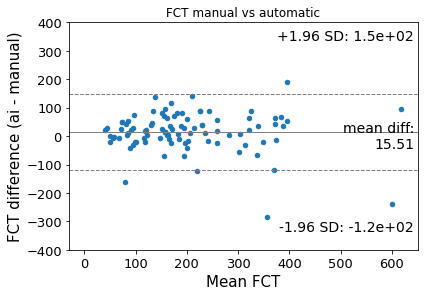

In [25]:
manual_fct, ai_fct = get_data_filtered(measurements, 'FCT test set', 'FCT model 2')
mean = np.mean([manual_fct, ai_fct], axis=0)
diff = manual_fct - ai_fct                   
md = np.mean(diff)                   
sd = np.std(diff, axis=0) 
print(sd)

fig, axes = plt.subplots()

sm.graphics.mean_diff_plot(ai_fct, manual_fct, ax = axes)
plt.xlabel('Mean FCT')
plt.ylabel('FCT difference (ai - manual)')
plt.title('FCT manual vs automatic')
plt.xlim(-30, 650)
plt.ylim(-400, 400)

In [26]:
outliers, outliers_data = find_outliers(ai_fct, manual_fct, measurements, 'tukey')
print(outliers)
print(outliers_data)


[ 9 19 23 61 72 93]
[{'pullback': 'NLD-AMPH-0011', 'frame': 280, 'ai': 481.0, 'manual': 720}, {'pullback': 'NLD-AMPH-0028', 'frame': 235, 'ai': 158.0, 'manual': 280}, {'pullback': 'NLD-AMPH-0028', 'frame': 320, 'ai': 310.0, 'manual': 430}, {'pullback': 'NLD-ISALA-0087', 'frame': 80, 'ai': 0.0, 'manual': 160}, {'pullback': 'NLD-ISALA-0089', 'frame': 481, 'ai': 492.0, 'manual': 300}, {'pullback': 'NLD-ISALA-0065-LAD', 'frame': 440, 'ai': 214.0, 'manual': 500}]


Found 11 FP and 5 FN. Total values are 96
29.739603400460247


(-75.0, 150.0)

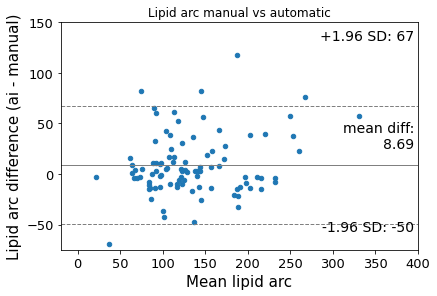

In [28]:
manual_arc, ai_arc = get_data_filtered(measurements, 'Lipid arc test set', 'Lipid arc model 2')
mean = np.mean([manual_arc, ai_arc], axis=0)
diff = manual_arc - ai_arc                  
md = np.mean(diff)                   
sd = np.std(diff, axis=0) 
print(sd)

fig, axes = plt.subplots()

sm.graphics.mean_diff_plot(ai_arc, manual_arc, ax = axes)
plt.xlabel('Mean lipid arc')
plt.ylabel('Lipid arc difference (ai - manual)')
plt.title('Lipid arc manual vs automatic')
plt.xlim(-20, 400)
plt.ylim(-75, 150)


In [29]:
outliers, outliers_data = find_outliers(ai_arc, manual_arc, measurements, 'tukey')
print(outliers)
print(outliers_data)

[14 24 66 72 93]
[{'pullback': 'NLD-AMPH-0028', 'frame': 167, 'ai': 116, 'manual': 34}, {'pullback': 'NLD-AMPH-0028', 'frame': 347, 'ai': 186, 'manual': 104}, {'pullback': 'NLD-ISALA-0087', 'frame': 339, 'ai': 306, 'manual': 230}, {'pullback': 'NLD-ISALA-0089', 'frame': 400, 'ai': 2, 'manual': 71}, {'pullback': 'NLD-ISALA-0065-LAD', 'frame': 400, 'ai': 246, 'manual': 128}]


## Pearson and ICC

Corr FCT: [[1.         0.83523301]
 [0.83523301 1.        ]]


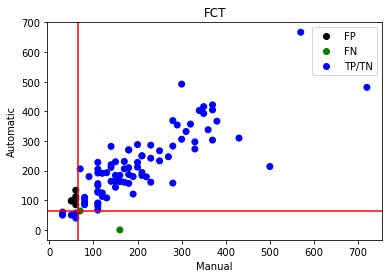

In [30]:
corr_plot(manual_fct, ai_fct, 65, 'FCT')

Corr Lipid arc: [[1.        0.8712927]
 [0.8712927 1.       ]]


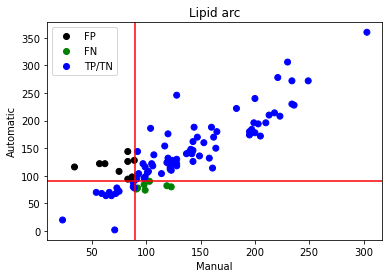

In [31]:
corr_plot(manual_arc, ai_arc, 90, 'Lipid arc')

In [32]:
calculate_icc(ai_fct, manual_fct)

,Type,Description,ICC,F,df1,df2,pval,CI95%
0,ICC1,Single raters absolute,0.827709,10.608291,94,95,7.987638e-26,"[0.75, 0.88]"
1,ICC2,Single random raters,0.828290,11.041993,94,94,2.657748e-26,"[0.75, 0.88]"
2,ICC3,Single fixed raters,0.833915,11.041993,94,94,2.657748e-26,"[0.76, 0.89]"
3,ICC1k,Average raters absolute,0.905734,10.608291,94,95,7.987638e-26,"[0.86, 0.94]"
4,ICC2k,Average random raters,0.906082,11.041993,94,94,2.657748e-26,"[0.86, 0.94]"
5,ICC3k,Average fixed raters,0.909437,11.041993,94,94,2.657748e-26,"[0.86, 0.94]"


In [33]:
calculate_icc(ai_arc, manual_arc)

,Type,Description,ICC,F,df1,df2,pval,CI95%
0,ICC1,Single raters absolute,0.856558,12.942888,95,96,1.393294e-29,"[0.79, 0.9]"
1,ICC2,Single random raters,0.857263,13.901023,95,95,1.285454e-30,"[0.79, 0.9]"
2,ICC3,Single fixed raters,0.865781,13.901023,95,95,1.285454e-30,"[0.81, 0.91]"
3,ICC1k,Average raters absolute,0.922737,12.942888,95,96,1.393294e-29,"[0.88, 0.95]"
4,ICC2k,Average random raters,0.923147,13.901023,95,95,1.285454e-30,"[0.88, 0.95]"
5,ICC3k,Average fixed raters,0.928063,13.901023,95,95,1.285454e-30,"[0.89, 0.95]"


# Manual vs automatic measurements (on manual segs)

## Bland Altman using same manual segmentations

Found 0 FP and 0 FN. Total values are 76


(-400.0, 400.0)

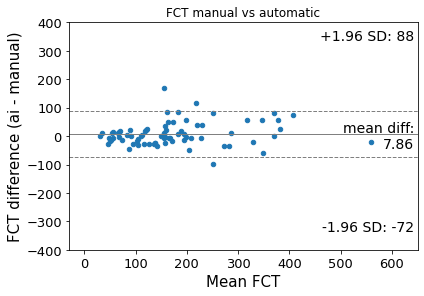

In [13]:
manual_fct, automatic_fct = get_data_filtered(measurements, 'FCT manual', 'FCT automatic')

fig, axes = plt.subplots()

sm.graphics.mean_diff_plot(automatic_fct, manual_fct, ax = axes)
plt.xlabel('Mean FCT')
plt.ylabel('FCT difference (ai - manual)')
plt.title('FCT manual vs automatic')
plt.xlim(-30, 650)
plt.ylim(-400, 400)

Found 0 FP and 0 FN. Total values are 76


(-75.0, 150.0)

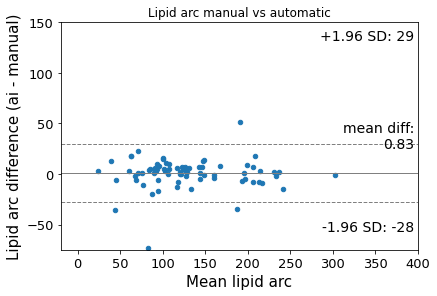

In [14]:
manual_arc, automatic_arc = get_data_filtered(measurements, 'Lipid arc manual', 'Lipid arc automatic')


fig, axes = plt.subplots()

sm.graphics.mean_diff_plot(automatic_arc, manual_arc, ax = axes)
plt.xlabel('Mean lipid arc')
plt.ylabel('Lipid arc difference (ai - manual)')
plt.title('Lipid arc manual vs automatic')
plt.xlim(-20, 400)
plt.ylim(-75, 150)


## Pearson and ICC 

Corr FCT: [[1.         0.94489705]
 [0.94489705 1.        ]]


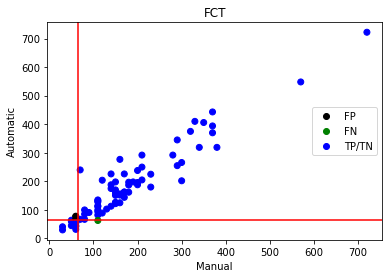

In [15]:
corr_plot(manual_fct, automatic_fct, 65, 'FCT')

Corr Lipid arc: [[1.         0.96704953]
 [0.96704953 1.        ]]


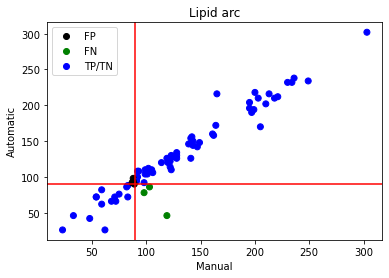

In [16]:
corr_plot(manual_arc, automatic_arc, 90, 'Lipid arc')

In [17]:
calculate_icc(automatic_fct, manual_fct)

,Type,Description,ICC,F,df1,df2,pval,CI95%
0,ICC1,Single raters absolute,0.942673,33.88754,75,76,3.316828e-38,"[0.91, 0.96]"
1,ICC2,Single random raters,0.942710,34.67031,75,75,3.881077e-38,"[0.91, 0.96]"
2,ICC3,Single fixed raters,0.943931,34.67031,75,75,3.881077e-38,"[0.91, 0.96]"
3,ICC1k,Average raters absolute,0.970491,33.88754,75,76,3.316828e-38,"[0.95, 0.98]"
4,ICC2k,Average random raters,0.970510,34.67031,75,75,3.881077e-38,"[0.95, 0.98]"
5,ICC3k,Average fixed raters,0.971157,34.67031,75,75,3.881077e-38,"[0.95, 0.98]"


In [18]:
calculate_icc(automatic_arc, manual_arc)

,Type,Description,ICC,F,df1,df2,pval,CI95%
0,ICC1,Single raters absolute,0.967365,60.283456,75,76,2.650079e-47,"[0.95, 0.98]"
1,ICC2,Single random raters,0.967359,59.684297,75,75,1.310311e-46,"[0.95, 0.98]"
2,ICC3,Single fixed raters,0.967043,59.684297,75,75,1.310311e-46,"[0.95, 0.98]"
3,ICC1k,Average raters absolute,0.983412,60.283456,75,76,2.650079e-47,"[0.97, 0.99]"
4,ICC2k,Average random raters,0.983409,59.684297,75,75,1.310311e-46,"[0.97, 0.99]"
5,ICC3k,Average fixed raters,0.983245,59.684297,75,75,1.310311e-46,"[0.97, 0.99]"
